In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch import nn, Tensor, TupleType
from torch.nn import Transformer

from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [2]:
mm_scaler = MinMaxScaler()

class StrideDataset(Dataset):
    def __init__(self, file_path, enc_seq_len, target_seq_len, x_size, stride=5):
        df = pd.read_csv(file_path)

        self.data = df.iloc[x_size:, 13:14].values
        self.data = self.data.squeeze()
        self.data = mm_scaler.fit_transform(self.data.reshape(-1, 1))
        self.data = self.data.squeeze()   
        
        self.length = len(df) - x_size

        num_samples = (self.length - enc_seq_len - target_seq_len) // stride + 1 #stride씩 움직일 때 생기는 총 sample 개수
        
        src = np.zeros([enc_seq_len, num_samples])
        trg = np.zeros([target_seq_len, num_samples])


        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + enc_seq_len
            src[:,i] = self.data[start_x:end_x]

            start_y = stride*i + enc_seq_len
            end_y = start_y + target_seq_len
            trg[:,i] = self.data[start_y:end_y]

        src = src.reshape(src.shape[0], src.shape[1], 1).transpose((1,0,2))
        trg = trg.reshape(trg.shape[0], trg.shape[1], 1).transpose((1,0,2))
        self.src = src
        self.trg = trg

        self.len = len(src)

    def __getitem__(self, i):
        return self.src[i], self.trg[i]
    
    def __len__(self):
        return self.len

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_path, x_size):
        df = pd.read_csv(file_path)

        self.x = df.iloc[x_size:, 6:10].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))
        self.y = df.iloc[x_size:, 13:14].values
        
        self.length = len(df) - x_size

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [4]:
train_dataset = StrideDataset("DST_80.csv", 10, 1, 1919, stride=1)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=False, drop_last=False)
dataset_d = CustomDataset("DST_80.csv", 1919)

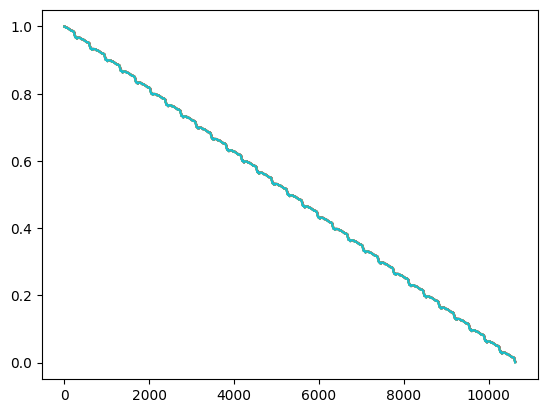

In [5]:
plt.plot(train_dataset.src.squeeze())

In [6]:
print(train_dataset.src.shape)
print(train_dataset.trg.shape)

(10629, 10, 1)
(10629, 1, 1)


In [7]:
print(dataset_d.y.shape)
print(dataset_d.y.shape)

(10639, 1)
(10639, 1)


In [8]:
class TFModel(nn.Module):
    def __init__(self,iw, ow, d_model, nhead, nlayers, dropout=0.5):
        super(TFModel, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=nlayers)        
        self.decoder = nn.Linear(d_model,1)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def gen_attention_mask(x):
    mask = torch.eq(x, 0)
    return mask

In [9]:
lr = 0.0001
model = TFModel(10, 1, 512, 8, 4, 0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [10]:
epoch = 100
model.train()
progress = tqdm(range(epoch))


for i in progress:
    batchloss = 0.0
    for (inputs, outputs) in train_dataloader:
        optimizer.zero_grad()
        result = model(inputs.float().to(device))
        loss = criterion(result, outputs[0,:,:].float().to(device))
        loss.backward()
        optimizer.step()
        batchloss += loss
    progress.set_description("loss: {:0.6f}".format(batchloss.cpu().item() / len(train_dataloader)))
    



    # for i in progress:
    # batchloss = 0.0

    # for (inputs, tgt, tgt_y) in train_dataloader:
    #     optimizer.zero_grad()

    #     result = model(src.float().to(device), tgt.float().to(device), src_mask, tgt_mask)
    #     loss = loss_func(result, tgt_y.float().to(device))

    #     loss.backward()
    #     optimizer.step()
    #     batchloss += loss
        
    # progress.set_description("{:0.5f}".format(batchloss.cpu().item() / len(train_dataloader)))#??

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([128, 10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([5, 10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
loss: 0.048358: 100%|██████████| 100/100 [03:43<00:00,  2.23s/it]


In [23]:
eval_dataset = StrideDataset("DST_80.csv", 10, 1, 1919, stride=1)
eval_dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=False, drop_last=False)

In [26]:
model.eval()

predictions = torch.Tensor(0)
actual = torch.Tensor(0)

with torch.no_grad():
    for (inputs, outputs) in eval_dataloader:
                
        result = model(inputs.float().to(device))
        print(result.shape)

        predictions = torch.cat((predictions, result.view(-1).cpu()), 0)




print(predictions.shape)



# model.eval()

# predictions = torch.Tensor(0)
# actual = torch.Tensor(0)



# with torch.no_grad():
#     for (inputs, dec_input, outputs) in eval_dataloader:
#         src_mask = model.generate_square_subsequent_mask(inputs.shape[1]).to(device)
#         tgt_mask = model.generate_square_subsequent_mask(dec_input.shape[1]).to(device)

#         output = model(inputs.float().to(device), dec_input.float().to(device), src_mask, tgt_mask)
        
#         predictions = torch.cat((predictions, output[-1].view(-1).cpu()), 0)
#         actual = torch.cat((actual, outputs[-1].view(-1).cpu()), 0)


# print(predictions.shape)

torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])
torch.Size([128, 10, 1])


In [ ]:
predictions = mm_scaler.inverse_transform(predictions.reshape(-1,1))

In [25]:
print(predictions.shape)

torch.Size([840])


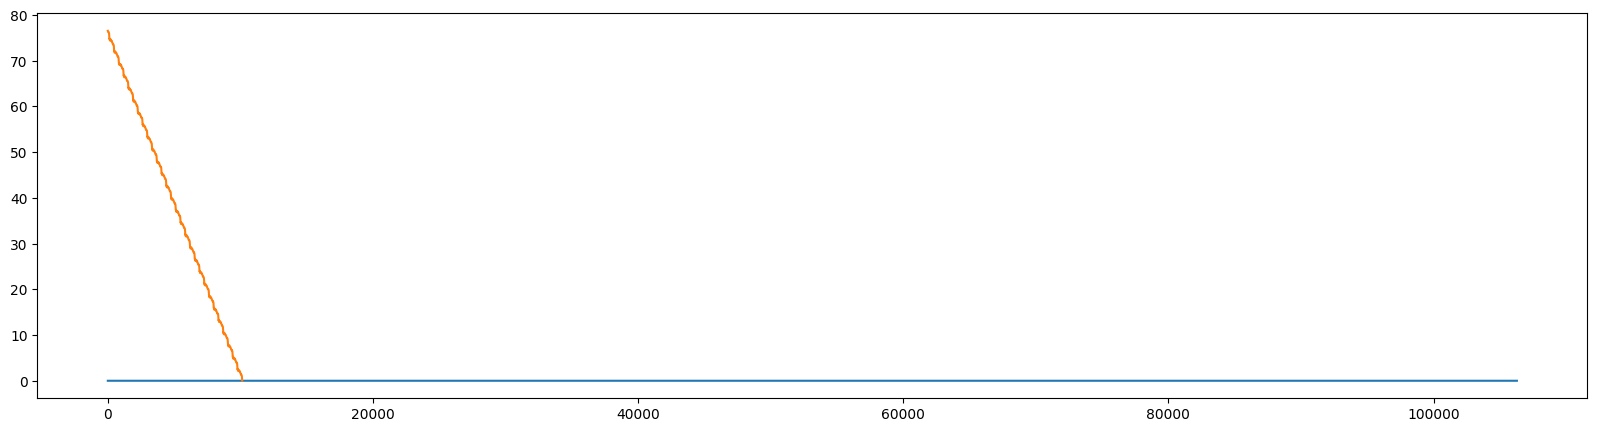

In [28]:
plt.figure(figsize=(20,5))
#plt.plot(range(20000-639,20000),dataset_d.y[20000-639:], label="real")
plt.plot(predictions, label="predict")
plt.plot(dataset_d.y[500:], label="real")
# plt.xlim([0, 100])
# plt.ylim([38.57, 38.60])

# plt.legend()
# plt.show()

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()